# Examining Correlation Between Data and Output

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import data

## Simple import

In [103]:
train_route = '../data/waiting_times_train.csv'
weather_route = '../data/weather_data.csv'

train_file = pd.read_csv(train_route)
weather_file = pd.read_csv(weather_route)

## Visualize data

### Train File

In [104]:
print(train_file.describe(include='all'))
print("----------------------------------------------------------------------")
print(train_file.dtypes)
print("----------------------------------------------------------------------")
print(train_file.head())

print(weather_file.describe(include='all'))
print("----------------------------------------------------------------------")
print(weather_file.dtypes)
print("----------------------------------------------------------------------")
print(weather_file.dropna().head())

                   DATETIME ENTITY_DESCRIPTION_SHORT  ADJUST_CAPACITY  \
count                 37018                    37018     37018.000000   
unique                17560                        3              NaN   
top     2021-11-30 13:15:00           Flying Coaster              NaN   
freq                      3                    14468              NaN   
mean                    NaN                      NaN       413.738352   
std                     NaN                      NaN       252.389589   
min                     NaN                      NaN         3.400000   
25%                     NaN                      NaN       247.000000   
50%                     NaN                      NaN       247.000000   
75%                     NaN                      NaN       756.000000   
max                     NaN                      NaN       756.000000   

            DOWNTIME  CURRENT_WAIT_TIME  TIME_TO_PARADE_1  TIME_TO_PARADE_2  \
count   37018.000000       37018.000000     

## Scatter Plots and Correlation Coefficients

In [126]:
X_train = train_file.copy()
X_train_ = X_train.sort_values(by='DATETIME')
print(X_train_[X_train_['ENTITY_DESCRIPTION_SHORT'] == 'Water Ride'][['DATETIME','ENTITY_DESCRIPTION_SHORT','CURRENT_WAIT_TIME','WAIT_TIME_IN_2H']].head(20))
X_train['DATETIME'] = pd.to_datetime(X_train['DATETIME'], errors='coerce')

weather_file['DATETIME'] = pd.to_datetime(weather_file['DATETIME'], errors='coerce')
weather_file = weather_file.fillna(0)

X_train = pd.merge(X_train, weather_file, on='DATETIME', how='left')
X_train = pd.get_dummies(X_train, columns=['ENTITY_DESCRIPTION_SHORT'], drop_first=True, dtype=int)
X_train['year'] = X_train['DATETIME'].dt.year
X_train['month'] = X_train['DATETIME'].dt.month
X_train['day'] = X_train['DATETIME'].dt.day
X_train['hour'] = X_train['DATETIME'].dt.hour
X_train['minute'] = X_train['DATETIME'].dt.minute

X_train = X_train.fillna(250)

X_train = X_train.sort_values(by='DATETIME')
print(X_train['DATETIME'].head())
X_train['CURRENT_WAIT_TIME__4'] = X_train['CURRENT_WAIT_TIME'].shift(-4)
X_train['CURRENT_WAIT_TIME__3'] = X_train['CURRENT_WAIT_TIME'].shift(-3)
X_train['CURRENT_WAIT_TIME__2'] = X_train['CURRENT_WAIT_TIME'].shift(-2)
X_train['CURRENT_WAIT_TIME__1'] = X_train['CURRENT_WAIT_TIME'].shift(-1)
X_train['CURRENT_WAIT_TIME_1'] = X_train['CURRENT_WAIT_TIME'].shift(1)
X_train['CURRENT_WAIT_TIME_2'] = X_train['CURRENT_WAIT_TIME'].shift(2)
X_train['CURRENT_WAIT_TIME_3'] = X_train['CURRENT_WAIT_TIME'].shift(3)

# Fill NaNs by column
for col in X_train.select_dtypes(include=['number']).columns:
    # Compute mean and std of non-NaN values
    mean = X_train[col].mean()
    std = X_train[col].std()
    
    # Find number of NaNs
    n_nan = X_train[col].isna().sum()
    
    # Generate random numbers for NaNs
    random_values = np.random.normal(loc=mean, scale=std, size=n_nan)
    
    # Fill NaNs
    X_train.loc[X_train[col].isna(), col] = random_values

X_train = X_train.sort_index()
y_train = X_train['WAIT_TIME_IN_2H']
X_train = X_train.select_dtypes(include=['number']).drop(columns=['WAIT_TIME_IN_2H'])



print(X_train.describe(include='all'))
print(y_train.head())
print(y_train.nunique())
print(np.sort(y_train.unique()))

                  DATETIME ENTITY_DESCRIPTION_SHORT  CURRENT_WAIT_TIME  \
5927   2018-10-01 12:15:00               Water Ride                 20   
23029  2018-10-01 12:30:00               Water Ride                 20   
20130  2018-10-01 12:45:00               Water Ride                 20   
14170  2018-10-01 13:00:00               Water Ride                 20   
22635  2018-10-01 13:15:00               Water Ride                 20   
18582  2018-10-01 13:30:00               Water Ride                 20   
15929  2018-10-01 14:00:00               Water Ride                 20   
13007  2018-10-01 14:15:00               Water Ride                 20   
20081  2018-10-01 14:30:00               Water Ride                 20   
24627  2018-10-01 14:45:00               Water Ride                 20   
4976   2018-10-01 15:00:00               Water Ride                 15   
14848  2018-10-01 15:15:00               Water Ride                 15   
3896   2018-10-01 15:30:00            

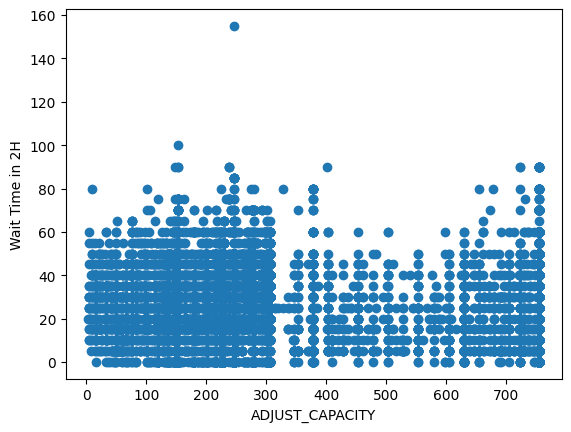

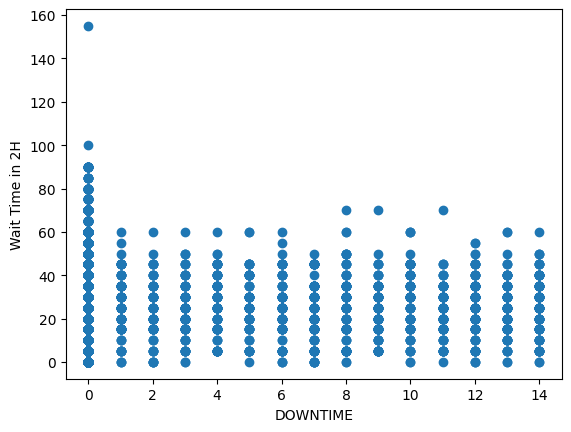

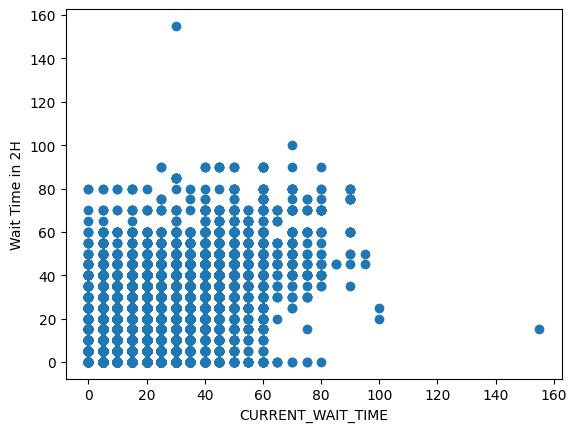

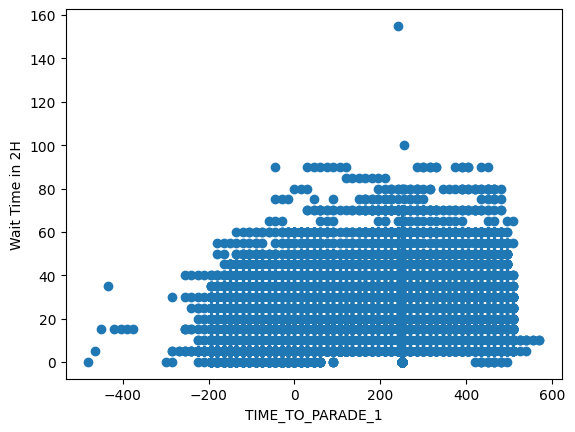

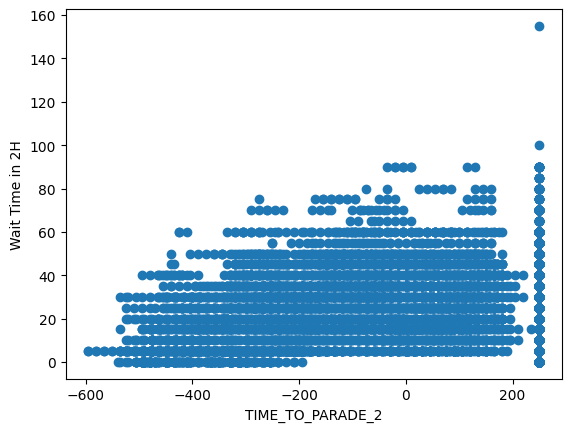

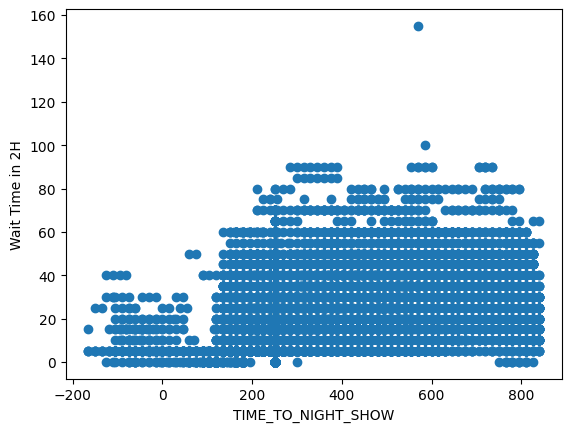

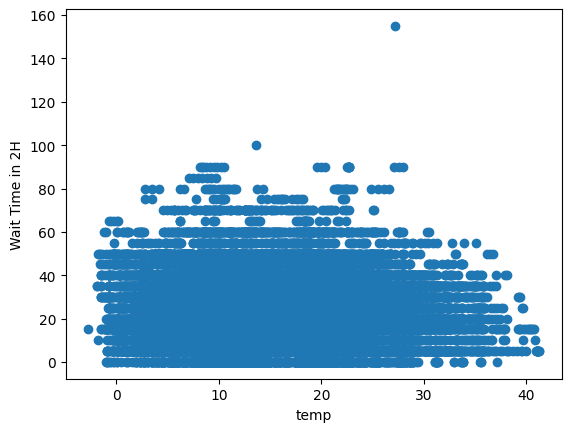

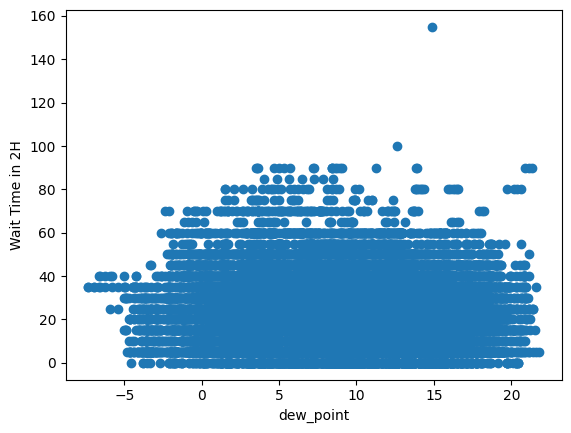

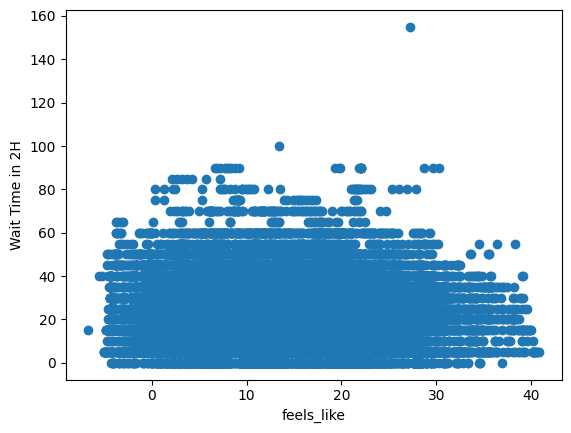

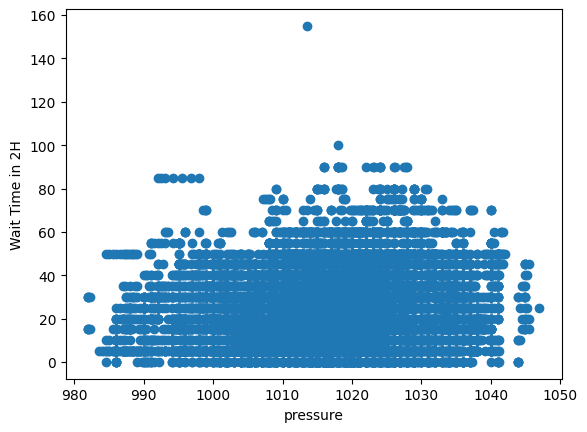

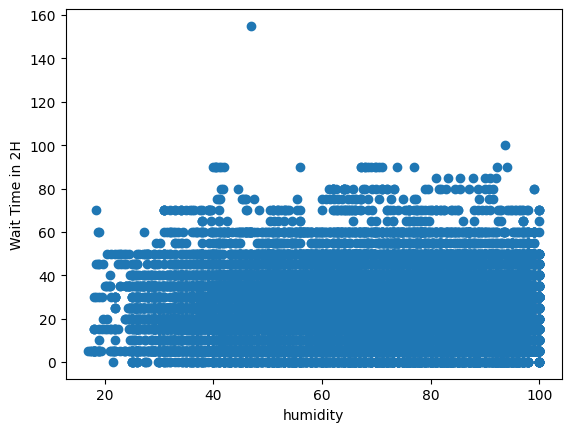

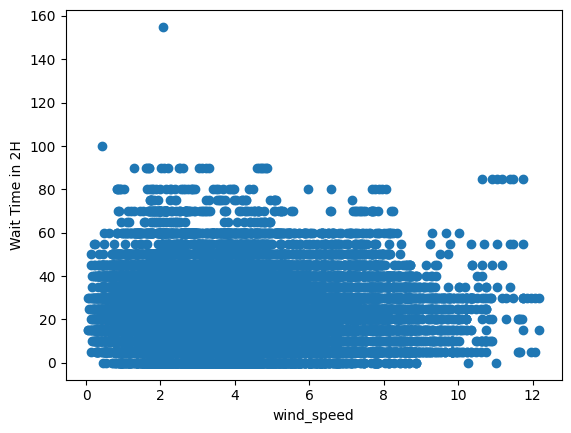

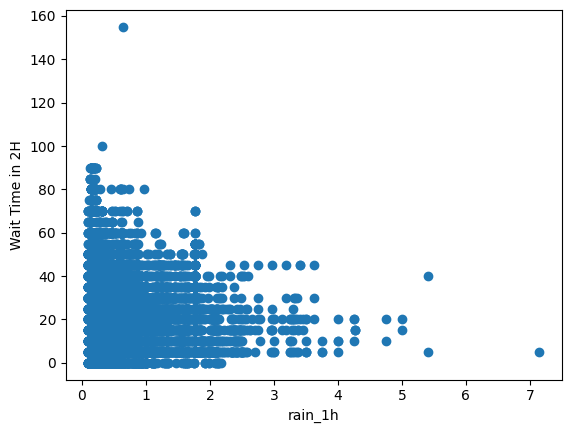

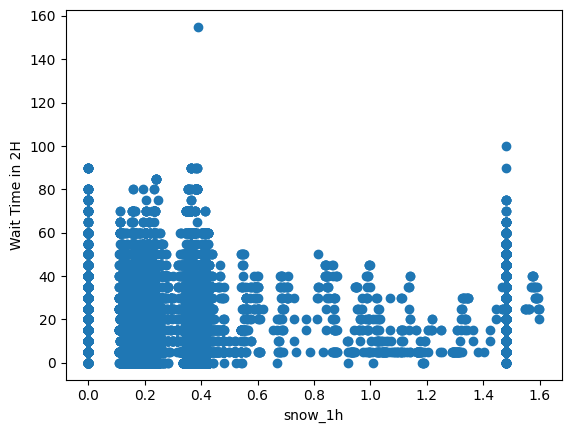

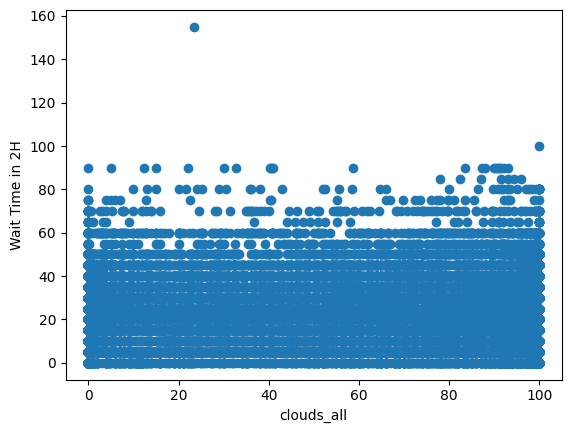

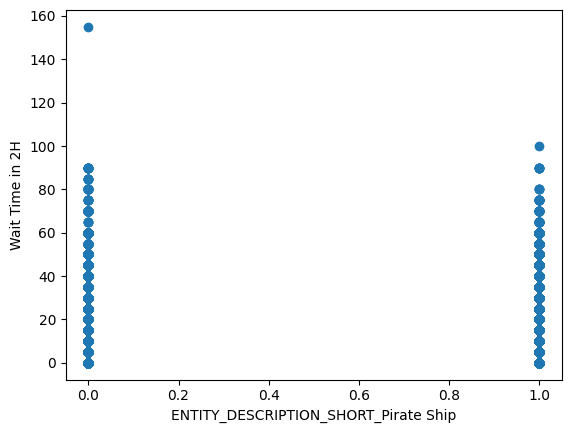

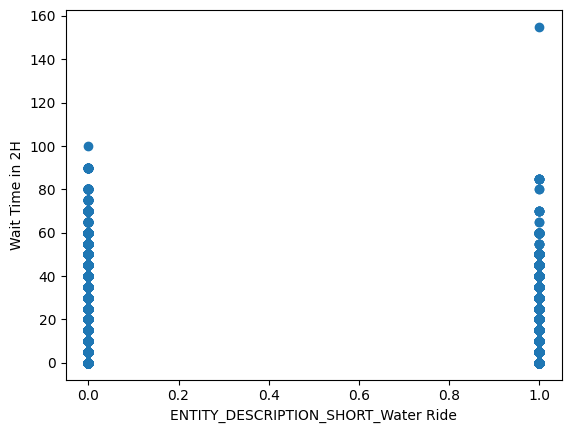

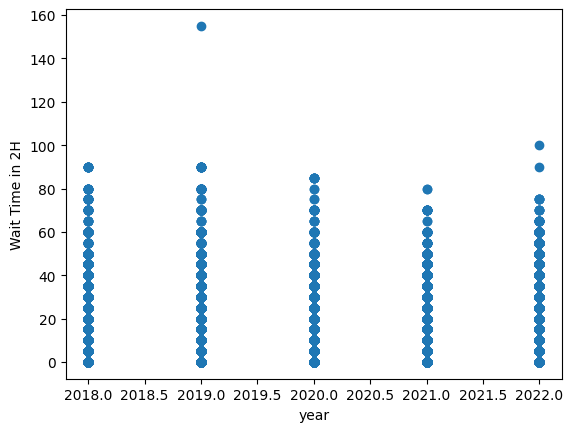

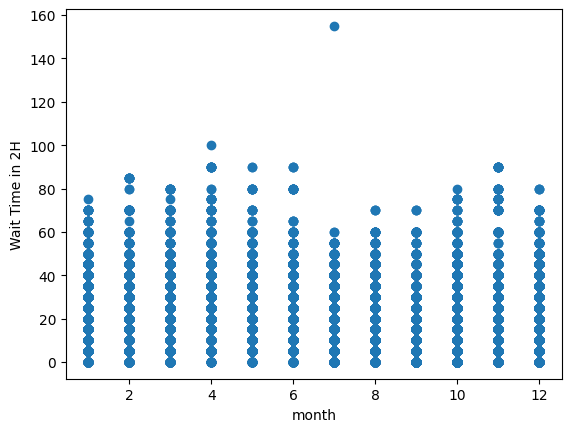

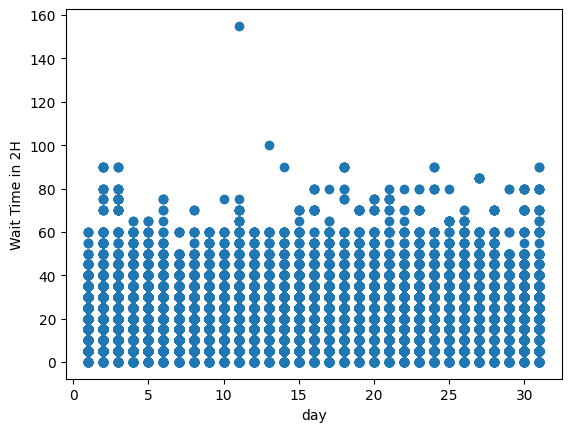

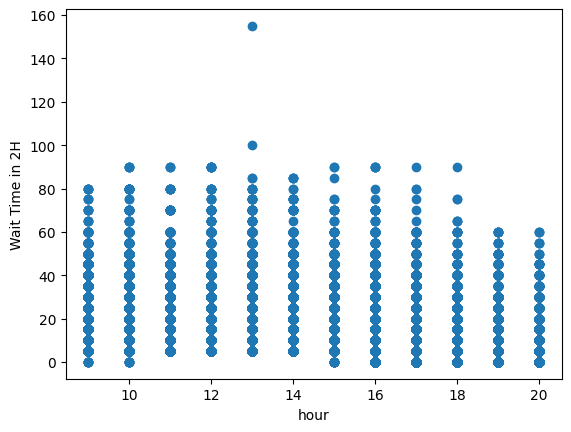

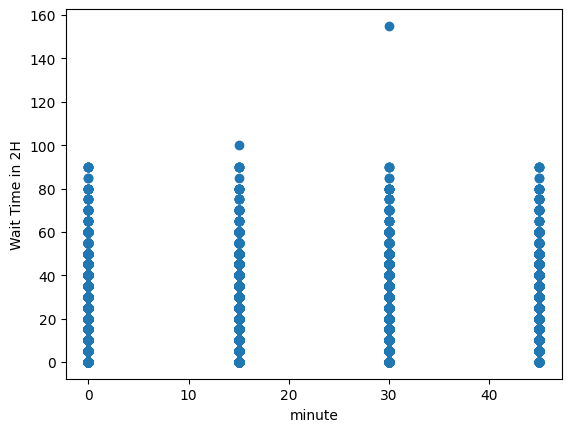

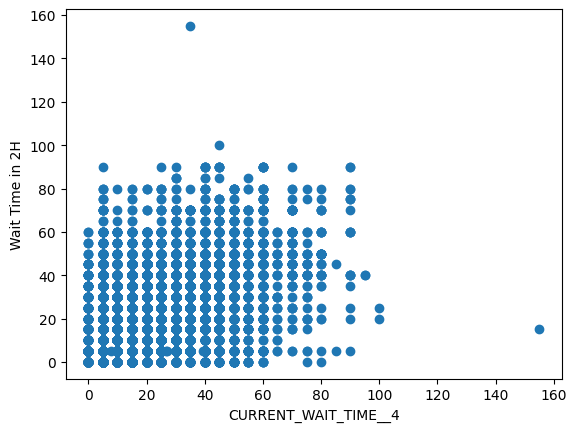

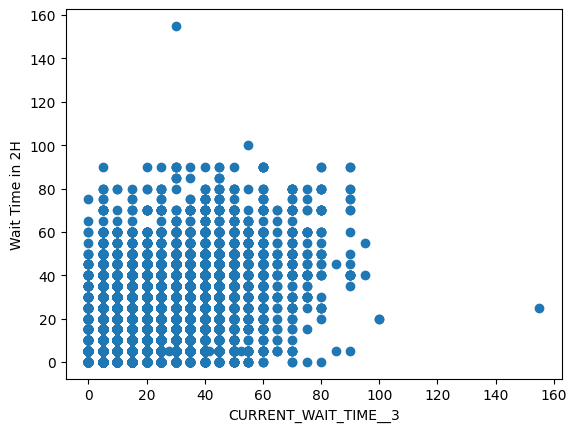

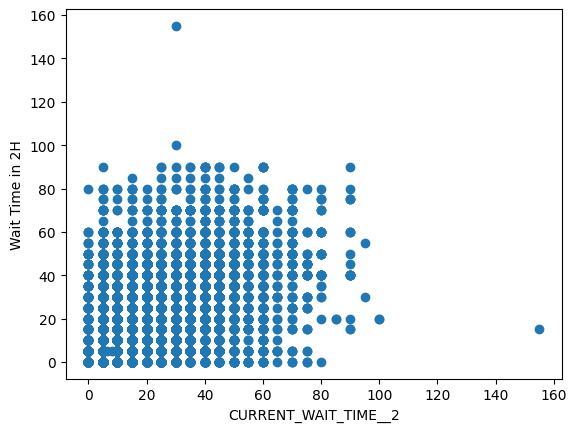

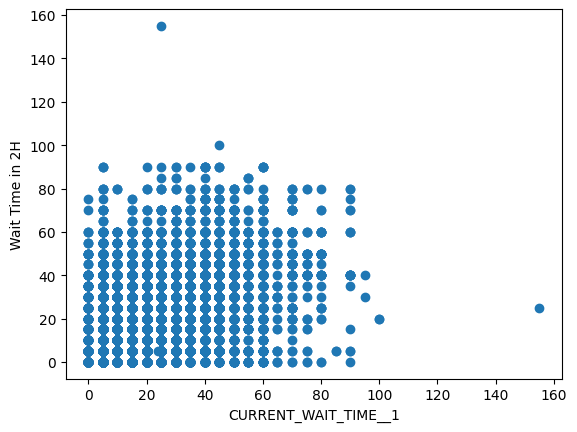

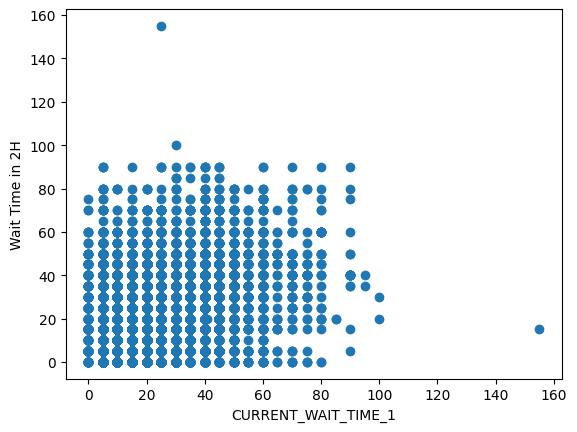

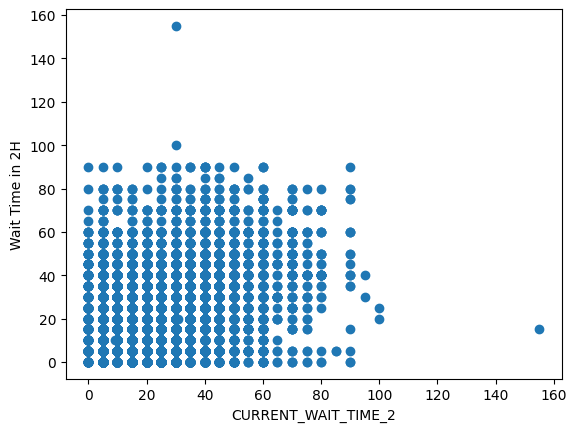

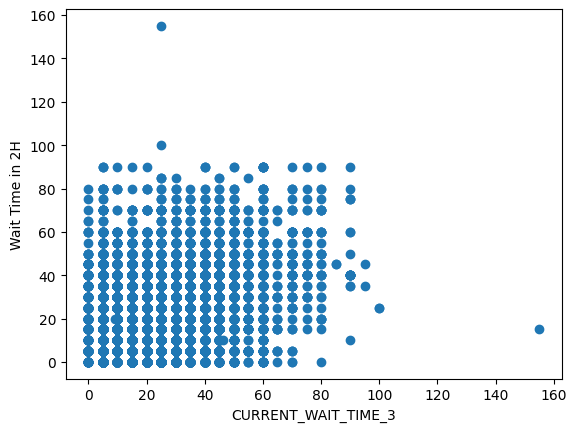

In [111]:
for name in X_train.columns:
    plt.scatter(X_train[name], y_train)

    # Add labels and title
    plt.xlabel(name)
    plt.ylabel("Wait Time in 2H")

    # Show the plot
    plt.show()

In [99]:
correlation_results = []

for name in X_train.columns:
    correlation_results.append(abs(X_train[name].corr(y_train)))

correlations = pd.DataFrame(np.array([X_train.columns, correlation_results]).T, columns=['Feature', 'Correlation']).sort_values(by='Correlation', ascending=False)
print(correlations)

                                 Feature Correlation
2                      CURRENT_WAIT_TIME     0.53515
26                  CURRENT_WAIT_TIME__5    0.447768
25                  CURRENT_WAIT_TIME__6    0.444848
27                  CURRENT_WAIT_TIME__4    0.444445
23                  CURRENT_WAIT_TIME__8    0.442885
24                  CURRENT_WAIT_TIME__7     0.44191
28                  CURRENT_WAIT_TIME__3    0.441406
22                  CURRENT_WAIT_TIME__9    0.438741
29                  CURRENT_WAIT_TIME__2    0.408245
30                  CURRENT_WAIT_TIME__1    0.364805
5                     TIME_TO_NIGHT_SHOW    0.356333
33                   CURRENT_WAIT_TIME_3    0.331878
32                   CURRENT_WAIT_TIME_2    0.331407
31                   CURRENT_WAIT_TIME_1    0.313603
20                                  hour      0.3042
3                       TIME_TO_PARADE_1    0.251653
15  ENTITY_DESCRIPTION_SHORT_Pirate Ship    0.197569
0                        ADJUST_CAPACITY    0.